In [548]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import seaborn as sns
import nltk
import difflib
from sklearn.decomposition import LatentDirichletAllocation

pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [842]:
def show_card(name=None,show=False):
    if name is None:
        card_name = input('Enter the name of a commander: ').strip()
        if card_name.lower()=='exit':
            return
    else:
        card_name = name
    try:
        card = commanders[commanders.index.str.lower()==card_name.lower()]
        response = requests.get(card.image_uris.tolist()[0]['normal'])
    except:
        closest = difflib.get_close_matches(card_name,commanders.index.tolist(),len(commanders.index.tolist()),0)[0]
        print(f"Could not find {card_name}. Instead showing {closest}.")
        card = commanders[commanders.index==closest]
        response = requests.get(card.image_uris.tolist()[0]['normal'])
    img = Image.open(BytesIO(response.content))
    if show==True:
        display(img)
    return card.image_uris.tolist()[0]['normal']

# Load cards and drop columns

In [32]:
commanders = pd.read_json('Data/commander_legal.json')

In [33]:
commanders.columns

Index(['all_parts', 'artist', 'cmc', 'color_identity', 'color_indicator',
       'colors', 'edhrec_rank', 'games', 'highres_image', 'image_uris', 'lang',
       'layout', 'legalities', 'loyalty', 'mana_cost', 'name', 'oracle_text',
       'oversized', 'power', 'preview', 'printed_text', 'printed_type_line',
       'promo', 'released_at', 'reprint', 'reserved', 'scryfall_uri', 'set',
       'set_name', 'set_search_uri', 'tcgplayer_id', 'textless', 'toughness',
       'type_line', 'pop_cmdr', 'w', 'u', 'b', 'r', 'g', 'wu', 'ub', 'br',
       'rg', 'gw', 'wb', 'ur', 'bg', 'rw', 'gu', 'wub', 'ubr', 'brg', 'rgw',
       'gwu', 'wbg', 'urw', 'bgu', 'rwb', 'gur', 'wubr', 'ubrg', 'brgw',
       'rgwu', 'gwub', 'wubrg', 'colorless'],
      dtype='object')

**Only include legendary creatures with a normal layout and no partner mechanic**

In [34]:
commanders = commanders[commanders.type_line.str.contains('Legendary Creature')]

In [35]:
commanders = commanders[commanders.layout=='normal']

In [36]:
commanders = commanders[~commanders.oracle_text.str.contains('Partner')]

**Dataset includes reprints as a separate row, so drop those to have a unique list**

In [37]:
commanders.drop_duplicates('name','last',inplace=True)

**Set the index of my DataFrame to the card name**

In [38]:
commanders.set_index('name',inplace=True)

In [50]:
commanders.head()

,all_parts,artist,cmc,color_identity,color_indicator,colors,edhrec_rank,games,highres_image,image_uris,lang,layout,legalities,loyalty,mana_cost,oracle_text,oversized,power,preview,printed_text,printed_type_line,promo,released_at,reprint,reserved,scryfall_uri,set,set_name,set_search_uri,tcgplayer_id,textless,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Ink-Eyes, Servant of Oni",None,Wayne Reynolds,6,[B],None,[B],1759.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,None,{4}{B}{B},"Ninjutsu {3}{B}{B} ({3}{B}{B}, Return an unblo...",False,5,None,NaN,NaN,False,2016-11-25,True,False,https://scryfall.com/card/pca/33/ink-eyes-serv...,pca,Planechase Anthology,https://api.scryfall.com/cards/search?order=se...,125443.0,False,4,Legendary Creature — Rat Ninja,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"Higure, the Still Wind",None,Christopher Moeller,5,[U],None,[U],2866.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,None,{3}{U}{U},"Ninjutsu {2}{U}{U} ({2}{U}{U}, Return an unblo...",False,3,None,NaN,NaN,False,2016-11-25,True,False,https://scryfall.com/card/pca/18/higure-the-st...,pca,Planechase Anthology,https://api.scryfall.com/cards/search?order=se...,125438.0,False,4,Legendary Creature — Human Ninja,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Zedruu the Greathearted,None,Mark Zug,4,"[R, U, W]",None,"[R, U, W]",3048.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,None,{1}{U}{R}{W},"At the beginning of your upkeep, you gain X li...",False,2,None,NaN,NaN,False,2016-11-11,True,False,https://scryfall.com/card/c16/231/zedruu-the-g...,c16,Commander 2016,https://api.scryfall.com/cards/search?order=se...,124013.0,False,4,Legendary Creature — Minotaur Monk,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"Sydri, Galvanic Genius",None,Terese Nielsen,3,"[B, U, W]",None,"[B, U, W]",2767.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,None,{W}{U}{B},{U}: Target noncreature artifact becomes an ar...,False,2,None,NaN,NaN,False,2016-11-11,True,False,https://scryfall.com/card/c16/224/sydri-galvan...,c16,Commander 2016,https://api.scryfall.com/cards/search?order=se...,124649.0,False,2,Legendary Creature — Human Artificer,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"Selvala, Explorer Returned",None,Tyler Jacobson,3,"[G, W]",None,"[G, W]",1198.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,None,{1}{G}{W},Parley — {T}: Each player reveals the top card...,False,2,None,NaN,NaN,False,2016-11-11,True,False,https://scryfall.com/card/c16/220/selvala-expl...,c16,Commander 2016,https://api.scryfall.com/cards/search?order=se...,124623.0,False,4,Legendary Creature — Elf Scout,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


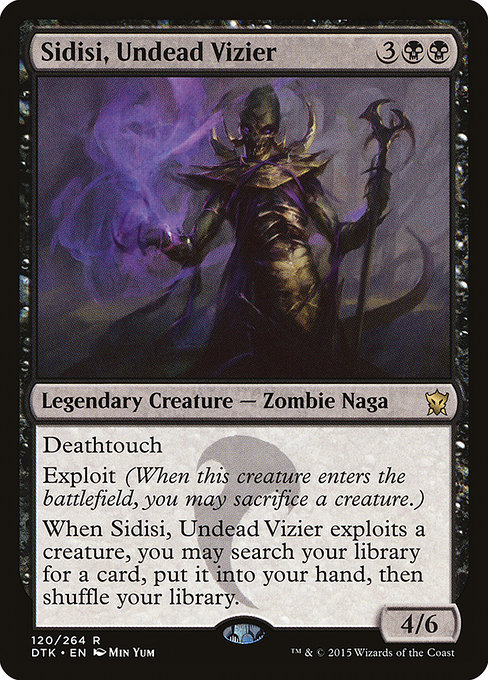

'https://img.scryfall.com/cards/normal/front/6/e/6ea5dbba-6114-4d97-9363-817ab9e896d3.jpg?1562788006'

In [42]:
show_card(commanders.sort_values('edhrec_rank').iloc[0].head().name,True)

## LDA to find topics of commanders

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords

**Stopwords started with standard english stopwords and the names of the cards. Other keywords were added manually after trial and error to see which words were appearing in too many topics at once**

In [724]:
stop = list(set(stopwords.words('english')))
names = [card_name.lower().replace(',','').split() for card_name in commanders.index]
for name in names:
    stop.extend(name)
stop += ['gain','give','each','among','least','less','choice','until','end','start','beginning','upkeep','may',
         'put','under','whenever','except','player','cost','turn','gets','get','pay','deals','control',
         'controls','color','order','lose','battlefield','target','spell','card','equal','ability','activate',
         'next','step','cast','owner','time','would','instead','number','onto','though','long',
         'choose','target','converted','mana','permanent','another','card','cards','horsemanship','flying','creature',
         'creatures','becomes']
stop = list(set(stop))

In [725]:
texts = [text.strip().lower() for text in commanders.oracle_text]

In [726]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=10,stop_words=stop, analyzer='word',ngram_range=(1,2)) # max_df=0.95, min_df=10,
tf = tf_vectorizer.fit_transform(texts)
tf_feature_names = tf_vectorizer.get_feature_names()

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ancestor', 'arms', 'ben', 'blossom', 'boar', 'cho', 'clad', 'corpse', 'dal', 'devouring', 'dûl', 'eight', 'eye', 'eyed', 'gilt', 'gitaxias', 'glass', 'gnawer', 'gold', 'half', 'heron', 'ihsan', 'il', 'ink', 'ishi', 'jiki', 'kagachi', 'kanar', 'kiki', 'kin', 'kuar', 'lim', 'manno', 'maro', 'marrow', 'mizzet', 'mors', 'nature', 'nephalia', 'night', 'niv', 'opal', 'palladia', 'phoenix', 'praetors', 'raze', 'rrik', 'sanity', 'scar', 'seasons', 'sek', 'selesnya', 'ship', 'shizo', 'sleeping', 'sol', 'spinner', 'striped', 'tail', 'tails', 'thousand', 'ur', 'yavimaya', 'zo', 'zu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [727]:
tf

<724x133 sparse matrix of type '<class 'numpy.int64'>'
	with 3835 stored elements in Compressed Sparse Row format>

In [728]:
# I want less topics so that topics are more general and have more overlap
lda=LatentDirichletAllocation(n_components=5,random_state=0,verbose=0,n_jobs=-1,max_iter=50)

In [729]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [730]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append({topic_idx:[feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]})
        print ("Topic %d:" % (topic_idx),end='\t')
        print ("\n\t\t".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]),end='\n\n')
    return topics

topic_words = display_topics(lda, tf_feature_names, 5)

Topic 0:	strike
		blocked
		spells
		library
		opponents

Topic 1:	library
		combat
		damage
		combat damage
		top

Topic 2:	opponent
		graveyard
		damage
		draw
		return

Topic 3:	counter
		enters
		power
		counters
		create

Topic 4:	token
		haste
		create
		white
		copy



In [762]:
cmdr_topics = pd.DataFrame(lda.transform(tf))
cmdr_topics.index = commanders.index
cmdr_topics.columns = ['Library Casters','Library Searchers','Steady Control','Snowballers','Army Makers']
cmdr_topics['edhrec_rank'] = commanders['edhrec_rank']

In [763]:
cmdr_topics.sort_values('Library Casters',ascending=False).head(10)

,Library Casters,Library Searchers,Steady Control,Snowballers,Army Makers,edhrec_rank
name,,,,,,
"Kaalia, Zenith Seeker",0.946083,0.013603,0.013386,0.013548,0.013381,7526.0
"Munda, Ambush Leader",0.945539,0.013813,0.013427,0.013578,0.013643,5222.0
"Jalira, Master Polymorphist",0.945384,0.013797,0.013777,0.013667,0.013374,4085.0
"Depala, Pilot Exemplar",0.942285,0.014756,0.014298,0.014286,0.014375,5072.0
Elsha of the Infinite,0.937692,0.015962,0.015403,0.015388,0.015555,4695.0
Niv-Mizzet Reborn,0.937664,0.015793,0.015446,0.015665,0.015432,3940.0
"Muzzio, Visionary Architect",0.935927,0.015777,0.017098,0.015385,0.015814,3772.0
"Tomorrow, Azami's Familiar",0.930850,0.016963,0.018470,0.017050,0.016667,4814.0
Tromokratis,0.925455,0.019746,0.018370,0.018182,0.018247,3310.0


In [764]:
cmdr_topics.describe()

,Library Casters,Library Searchers,Steady Control,Snowballers,Army Makers,edhrec_rank
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.176012,0.186640,0.254486,0.215999,0.166863,5225.256906
std,0.248054,0.260863,0.289289,0.272120,0.238705,4195.012044
min,0.010053,0.010855,0.010021,0.010543,0.010559,179.000000
25%,0.025478,0.028668,0.028895,0.028834,0.028572,2101.500000
50%,0.050000,0.050097,0.068396,0.054068,0.050000,4027.000000
75%,0.200000,0.202456,0.451954,0.338398,0.200000,6888.750000
max,0.946083,0.948039,0.949811,0.937917,0.948377,19144.000000


In [860]:
def recommend_by_commander():
    topics = cmdr_topics.columns[:-1]
    inpt = input("Enter a commander(s) you like: ")
    if inpt not in cmdr_topics.index.tolist():
        inpt = difflib.get_close_matches(inpt,cmdr_topics.index.tolist(),len(cmdr_topics.index.tolist()),0)[0]
    inpt_row = cmdr_topics.loc[inpt]
    scores = pd.Series(index=cmdr_topics.index)
    scores.loc[inpt] = -1
    for idx, row in cmdr_topics.drop(index=inpt).iterrows():
        scores.loc[idx] = sum([(row.loc[topic]-inpt_row.loc[topic])**2 for topic in topics])
    print(f"Showing commanders most similar to: {inpt}")
    return scores.sort_values()

In [864]:
recommend_by_commander()

Enter a commander you like: Kaalia, Zenith Seeker	
Showing commanders most similar to: Kaalia, Zenith Seeker


name
Kaalia, Zenith Seeker             -1.000000e+00
Munda, Ambush Leader               4.111293e-07
Jalira, Master Polymorphist        6.938316e-07
Depala, Pilot Exemplar             1.811935e-05
Elsha of the Infinite              8.815535e-05
Niv-Mizzet Reborn                  8.860099e-05
Muzzio, Visionary Architect        1.309453e-04
Tomorrow, Azami's Familiar         2.922307e-04
Tromokratis                        5.332438e-04
Kwende, Pride of Femeref           2.654637e-03
Gaddock Teeg                       4.623162e-03
Shu Yun, the Silent Tempest        4.635216e-03
Zetalpa, Primal Dawn               4.662078e-03
Atarka, World Render               4.752597e-03
Rafiq of the Many                  4.783202e-03
Ulamog, the Ceaseless Hunger       4.808321e-03
Lorthos, the Tidemaker             4.861901e-03
Sigarda, Host of Herons            5.531662e-03
Gonti, Lord of Luxury              7.355641e-03
Zuo Ci, the Mocking Sage           7.912858e-03
Thrun, the Last Troll              

In [834]:
def recommend_by_topic():
    topics = cmdr_topics.columns[:-1]
    print("Enter number(s) of archtypes you like separated by spaces:")
    for topic_idx in range(len(topics)):
        print(f"\t{topic_idx+1}. {topics[topic_idx]}")
    likes = input().split()
    try:
        likes = list(map(int,likes))
    except:
        print("Non-digit entered.")
        return
    likes = list(set(likes))
    if len(likes)==0:
        return
    if min(likes) < 1 or max(likes) > len(topics):
        print('Entered a number out of range')
        return
    likes = [topics[i-1] for i in likes]
    top_recs = (cmdr_topics[likes]-(1/len(likes))).abs().sum(axis=1)
    top_recs = top_recs[top_recs < 0.4]
    top_recs = (top_recs*100000) + cmdr_topics['edhrec_rank']
    top_recs = top_recs.sort_values().dropna().index.tolist()
    print("--------------------------------------------------------------------")
    print(f"Found {len(top_recs)} possible commanders")
    print(f"I recommend these commanders for {', '.join(likes)}")
    offset = 1
    while(1):
        for idx in range(offset,offset+5):
            print(f"\t{idx}. {top_recs[idx-1]}\n{show_card(top_recs[idx-1])}")
        move = input("(N)ext or (P)rev? ").lower().strip()
        if move == 'next' or move == 'n':
            offset += 5
        elif move == 'prev' or move == 'p':
            offset -= 5
        else:
            return
        if offset < 0 or offset+5 > len(top_recs):
            print("End of list.")
            return
    
#     scores = cmdr_topics[likes].diff(axis=1).fillna(0).abs().sum(axis=1)
#     print(scores.sort_values())

In [828]:
recommend_by_topic()

Enter number(s) of archtypes you like separated by spaces:
	1. Library Casters
	2. Library Searchers
	3. Steady Control
	4. Snowballers
	5. Army Makers
	6. edhrec_rank
1
--------------------------------------------------------------------
Found 69 possible commanders
I recommend these commanders for Library Casters
	1. Jalira, Master Polymorphist
https://img.scryfall.com/cards/normal/front/1/f/1f9719c8-2dfe-4141-9ede-2ee3a282b5e9.jpg?1562433489
	2. Niv-Mizzet Reborn
https://img.scryfall.com/cards/normal/front/5/6/56a2609d-b535-400b-81d9-72989a33c70f.jpg?1559959440
	3. Muzzio, Visionary Architect
https://img.scryfall.com/cards/normal/front/1/7/170926b9-4bfa-4a9b-a297-db1672bc48d9.jpg?1562864474
	4. Munda, Ambush Leader
https://img.scryfall.com/cards/normal/front/d/8/d8ee09fe-46d7-492b-a2f3-3fb0c3f83f07.jpg?1562946697
	5. Tromokratis
https://img.scryfall.com/cards/normal/front/6/9/69fcad7f-2740-49ff-a448-4b232c456e16.jpg?1562508560
(N)ext or (P)rev? 


In [832]:
def recommender():
    while(1):
        print("How would you like to be recommended a new Commander? (Enter the number)")
        print("\t1. There's a commander I liked playing before!")
        print("\t2. I want some general playstyles to chooose from.")
        print("\t3. WHAT'S COMMANDER???")
        how = input().strip()
        if how == '':
            return
        try:
            how = int(how)
            if how == 3:
                print("""
-----------------------------------------------------------------------------------
   "Commander is an exciting, unique way to play Magic that is all about awesome 
    legendary creatures, big plays, and battling your friends in epic multiplayer 
    games! In Commander, each player chooses a legendary creature as the commander 
    of their deck. They then play with a 99-card deck that contains only cards of 
    their commander's colors. Also, other than basic lands, each deck can only use 
    one copy of any card. During the game, you can cast your commander multiple 
    times, meaning your favorite Legendary Creature can come back again and again 
    to lead the charge as you battle for victory!"
        Taken from Wizards of the Coast site.
-----------------------------------------------------------------------------------
""")
            elif how in [1,2]:
                break
            else:
                print('Enter 1, 2, or 3')
        except ValueError:
            print('Enter 1, 2, or 3.')
    if how == 1:
        return "TO BE IMPLEMENTED"
    elif how == 2:
        recommend_by_topic()

In [836]:
recommender()

How would you like to be recommended a new Commander? (Enter the number)
	1. There's a commander I liked playing before!
	2. I want some general playstyles to chooose from.
	3. WHAT'S COMMANDER???
2
Enter number(s) of archtypes you like separated by spaces:
	1. Library Casters
	2. Library Searchers
	3. Steady Control
	4. Snowballers
	5. Army Makers
5
--------------------------------------------------------------------
Found 63 possible commanders
I recommend these commanders for Army Makers
	1. Brimaz, King of Oreskos
https://img.scryfall.com/cards/normal/front/f/5/f54eb705-6326-4bac-bf0e-68d42db7a270.jpg?1562523521
	2. Inalla, Archmage Ritualist
https://img.scryfall.com/cards/normal/front/7/c/7c6e803a-451c-4aa6-97a2-400077f32c47.jpg?1562613987
	3. Kiki-Jiki, Mirror Breaker
https://img.scryfall.com/cards/normal/front/a/2/a2ff0ee3-9600-4c7d-acec-6ec90595384e.jpg?1562852476
	4. Zada, Hedron Grinder
https://img.scryfall.com/cards/normal/front/b/a/baa36309-4bcc-4455-813a-c0243b906792.jpg?1

In [ ]:
# 